## Principle Component Analysis (PCA)
Notes and experiments from http://machinelearningcoban.com/2017/06/15/pca/

___PCA process to reduce dimensions of data from d-D to k-D___:
- Step 1: Adjust the data so that its mean equals 0 (by subtract by its mean)
- Step 2: Compute covariance matrix $\Sigma \in \mathbf{R}^{d x d}$
- Step 3: Compute eigenvalues and eigenvectors of the $\Sigma$
- Step 4: Form the feature matrix by choosing $k$ eigenvectors corresponding to $k$ largest eigen values
- Step 5: Project data using the feature matrix

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import linalg as LA

# X: data
# k: number of PCA components to keep
# Return:
# - X_projected: projected data to kD dimension
# - S: orthogonal matrix used to project data
def pca_transform(X, k):
    n, d = X.shape

    # Step 1
    X_adj = X - X.mean(axis=0)
    
    # Step 2
    cov = 1/n * X_adj.T.dot(X_adj)
    
    # Step 3
    eigenvalues, eigenvectorsT = LA.eig(cov)
    
    # Step 4
    sorted_indices = np.argsort(-eigenvalues)[:k]
    S = eigenvectorsT.T[sorted_indices]
    
    # Step 5
    X_projected = X_adj.dot(S.T)
    return X_projected, S

### Try PCA with simple data
Let's use PCA to rotate 2D data points to a new basic in which the distribution along an axis is around the mean, and hence could be reduced.

Ref: http://www.cs.otago.ac.nz/cosc453/student_tutorials/principal_components.pdf

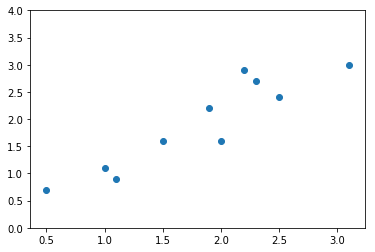

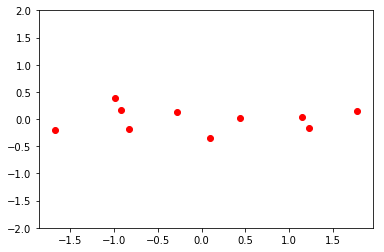

In [2]:
X = np.array([[2.5, 2.4], [0.5, 0.7], [2.2, 2.9], [1.9, 2.2], [3.1, 3.0], [2.3, 2.7], [2, 1.6], [1, 1.1], [1.5, 1.6], [1.1, 0.9]])
plt.scatter(X[:, 0], X[:, 1])
plt.ylim(0, 4)
plt.show()

X_projected, _ = pca_transform(X, k=2)

plt.scatter(X_projected[:, 0], X_projected[:, 1], color='red')
plt.ylim(-2, 2)
plt.show()

### Try PCA with IRIS

In [3]:
import pandas as pd

iris = pd.read_csv('data/iris.csv', header=None)
iris.columns = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm', 'Species']


def plot_iris(X, title, xlabel, ylabel):
    X0 = X[np.where(iris.Species == 'Iris-setosa')]
    X1 = X[np.where(iris.Species == 'Iris-versicolor')]
    X2 = X[np.where(iris.Species == 'Iris-virginica')]
    
    plt.scatter(X0[:, 0], X0[:, 1], color='red')
    plt.scatter(X1[:, 0], X1[:, 1], color='blue')
    plt.scatter(X2[:, 0], X2[:, 1], color='green')
    plt.legend(['Setosa', 'Versicolor', 'Virginica'])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

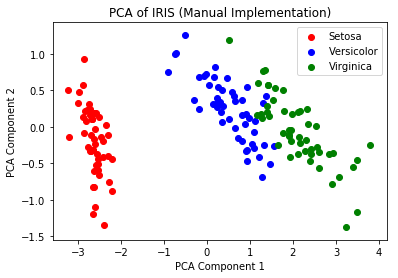

In [4]:
X = np.array(iris[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']])

X_projected, _ = pca_transform(X, k=2)
plot_iris(X_projected, title='PCA of IRIS (Manual Implementation)', xlabel='PCA Component 1', ylabel='PCA Component 2')

#### Use PCA of sklearn and compare the plots

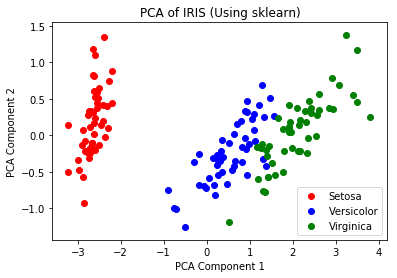

In [5]:
# Using sklearn.decomposition
from sklearn.decomposition import PCA

X = np.array(iris[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']])
pca = PCA(n_components=2)
X_projected = pca.fit_transform(X)

plot_iris(X_projected, title='PCA of IRIS (Using sklearn)', xlabel='PCA Component 1', ylabel='PCA Component 2')

Note: the two plots (manual implement and sklearn) are mirror-symmetric to each other because of a special property of eigenvector:

_if $v$ is an eigenvector of $A$, then with each constant $a$: $a*v$ is also an eigenvector of $A$ (in this case, $k = -1$)_

---
### PCA in practice
In practice, our data has a large amount of dimensions which leads to hugely heavy computations to determine eigenvalues and eigenvectors of a matrix. Some beautiful properties as follows help us sufficiently compute eigenvalues and eigenvectors.

(1) If $\lambda$ is an eigenvalue of $A.B$ (where $A \in \mathbf{R}^{d1xd2}, B \in \mathbf{R}^{d2xd1}$), then $\lambda$ is also an eigen value of $B.A$

(2) If $(\lambda, u)$ is a pair of eigenvalue and eigenvector of $T = X^T.X$, then $(\lambda, X.u)$ is a pair of eigenvalue and eigenvector of $S = X.X^T$


#### Case D is large, N << D:
We could calculate the eigenvalues and eigenvectors of a covariance matrix based on a smaller matrix
- From (1), instead of directly determining eigenvalues of $S = X.X^T \in \mathbf{R}^{DxD}$, we compute eigenvalues of $T = X^T.X \in \mathbf{R}^{NxN}$ (much smaller matrix).
- From (2), we compute eigenvectors of T (smaller matrix), and finally achieve the results by: $(\lambda, X.u)$

We have some experiments to verify the properties above

In [6]:
import numpy as np
from numpy.linalg import linalg as LA

def check_eig(A, eigenvalue, eigenvector):
    return np.allclose(A.dot(eigenvector), eigenvalue * eigenvector)

A = np.random.rand(1000, 100)  # N = 100, D = 10
S = A.dot(A.T)  # S: 1000x1000
T = A.T.dot(A)  # T: 100x100
print('S.shape: {}. T.shape: {}'.format(S.shape, T.shape))

S.shape: (1000, 1000). T.shape: (100, 100)


In [7]:
# Now look at the time it takes to compute eigenvalues and eigenvectors of S and T. Quite significant!
# The calculations for S is much more expensive than for T
# ---------------------------------------------
%time eigenvalues1, eigenvectors1T = LA.eig(S)
%time eigenvalues2, eigenvectors2T = LA.eig(T)
eigenvectors1 = eigenvectors1T.T
eigenvectors2 = eigenvectors2T.T

CPU times: user 1.79 s, sys: 170 ms, total: 1.96 s
Wall time: 1.06 s
CPU times: user 6.34 ms, sys: 188 µs, total: 6.53 ms
Wall time: 6.23 ms


In [8]:
# Now, we compute an eigenvector of S based on the an eigenvector of T (by property (2))
# ---------------------------------------------
check_eig(S, eigenvalues2[0], A.dot(eigenvectors2[0]))

True

#### Case N and D are both large
We could use the _Power Method_: http://www.cs.huji.ac.il/~csip/tirgul2.pdf

TODO: TBU